# 04_check_the_fitting

In [1]:
from pigeon_feather.data import *
from pigeon_feather.plot import *
from pigeon_feather.hxio import *
from pigeon_feather.spectra import *


import numpy as np
import pandas as pd

import datetime
import os
import pickle
import datetime

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


In [2]:
# load the pickle file we saved in the previous notebook


today = datetime.date.today().strftime("%Y%m%d")
today = "20240722"

with open(f"./data/hdxms_data_raw_{today}.pkl", "rb") as f:
    hdxms_data_list = pickle.load(f)


# back exchange correction for peptides with experimental full deuteration data based its closest match in the database
tools.backexchange_correction(hdxms_data_list)

Number of peptides with experimental max_d: 358
Number of peptides with no experimental max_d: 12


In [3]:
# make folders for results

today_date = datetime.date.today().strftime("%Y%m%d")
# today_date = '20240722'
results_path = f"ecDHFR_results_{today_date}"

if not os.path.exists(results_path):
    os.makedirs(results_path)


out_path = "./data/PF_input_20240722"

Create an `Analysis` object and load the results. **Note:** The temperature and pH are crucial for calculating the intrinsic exchange rates, so make sure to input the correct values. The chunk size and chunk number can be altered by the user. In this tutorial, they were automatically determined by a helper function.


In [4]:
from pigeon_feather.analysis import Analysis, get_index_offset
from pigeon_feather.tools import optimal_chunks
import matplotlib.pyplot as plt

RUN_NUM = 3

apo_states = [
    state
    for data in hdxms_data_list
    for state in data.states
    if state.state_name == "APO"
]

tri_states = [
    state
    for data in hdxms_data_list
    for state in data.states
    if state.state_name == "TRI"
]

ana_apo_1 = Analysis(apo_states, temperature=293.0, pH=7.0)

chunk_num, chunk_size = optimal_chunks(len(ana_apo_1.protein_sequence))
ana_apo_1.load_bayesian_hdx_oupt_chunks(
    chunk_size=chunk_size,
    chunk_num=chunk_num,
    state_name="APO",
    run_num=RUN_NUM,
    N=200,
    bayesian_hdx_data_folder=f"{out_path}/bayesian_hdx_output_chunks",
)


ana_tri_1 = Analysis(tri_states, temperature=293.0, pH=7.0)

ana_tri_1.load_bayesian_hdx_oupt_chunks(
    chunk_size=chunk_size,
    chunk_num=chunk_num,
    state_name="TRI",
    run_num=RUN_NUM,
    N=200,
    bayesian_hdx_data_folder=f"{out_path}/bayesian_hdx_output_chunks",
)

two fitting check functions are available: 1. centroid level fitting check 2. isotopic mass envelope fitting check. 


In [5]:
from pigeon_feather.analysis import (
    check_fitted_isotope_envelope,
    check_fitted_peptide_uptake,
)

## envelope check

In [6]:
check_state_name = "APO"
check_ana_obj = ana_apo_1


all_peps = [
    pep
    for data in hdxms_data_list
    for state in data.states
    for pep in state.peptides
    if state.state_name == check_state_name and pep.note is None
]
all_tps = [
    tp
    for pep in all_peps
    for tp in pep.timepoints
    if pep.get_timepoint(0) is not None and tp.deut_time != np.inf and tp.deut_time != 0
]


0.18336607065124264

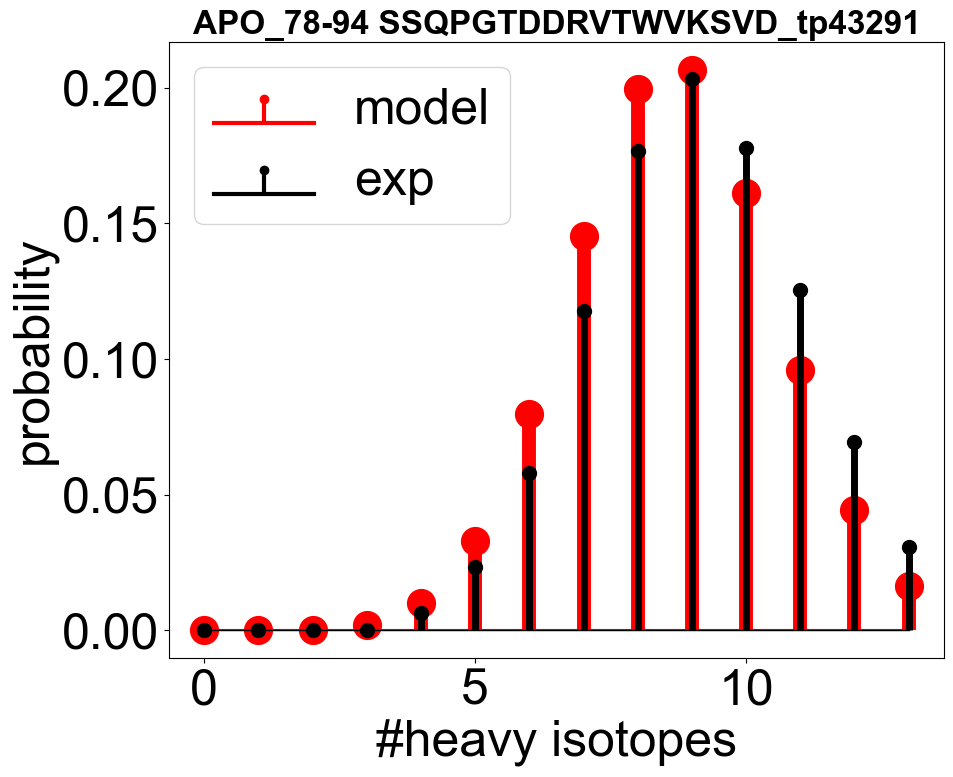

In [7]:
envelope_errors = [(check_fitted_isotope_envelope(ana_apo_1, tp), tp) for tp in all_tps]
envelope_errors = sorted(envelope_errors, key=lambda x: x[0], reverse=False)

# you can plot the fitted isotope envelope and the experimental data
check_fitted_isotope_envelope(check_ana_obj, envelope_errors[300][1], if_plot=True)

Text(0, 0.5, 'Count')

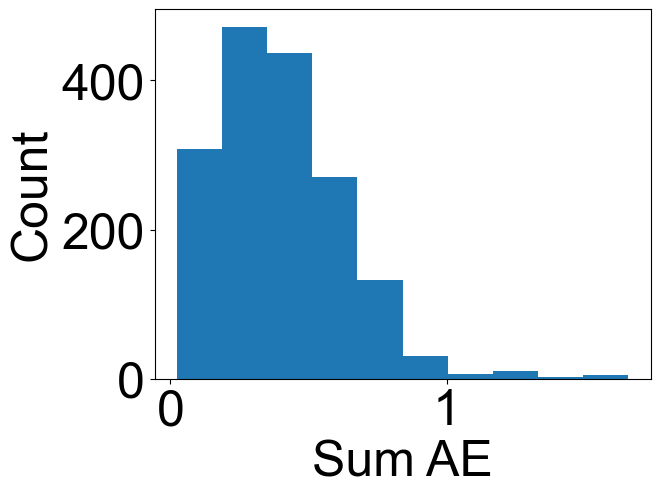

In [8]:
plt.hist(
    np.array(envelope_errors)[:, 0],
)
plt.xlabel("Sum AE")
plt.ylabel("Count")

In [9]:

print(np.nanmedian(np.array(envelope_errors)[:, 0]))
print(np.nanmean(np.array(envelope_errors)[:, 0]))

0.3669856716168908
0.39744791298433696


## uptake check

In [10]:
from pigeon_feather.analysis import check_fitted_peptide_uptake


all_idfs = list(set([pep.identifier for pep in all_peps]))


def extract_numbers(s):
    numbers = re.findall(r"(-?\d+)-(-?\d+)", s)
    return tuple(map(int, numbers[0]))


all_idfs.sort(key=extract_numbers)

In [11]:
uptake_errors = []

all_peps_grouped = tools.group_by_attributes(
    all_peps, ["protein_state.state_name", "identifier"]
)

for idf in all_idfs:
    try:
        idf_peps = all_peps_grouped[(check_state_name, idf)]
        avg_pep = tools.average_peptides(idf_peps)

        result = check_fitted_peptide_uptake(
            check_ana_obj, hdxms_data_list, avg_pep, state_name=check_state_name
        )
        uptake_errors.append((result, avg_pep))
    except Exception as e:
        print(idf, e)


uptake_errors_array = np.array([i[0] for i in uptake_errors])

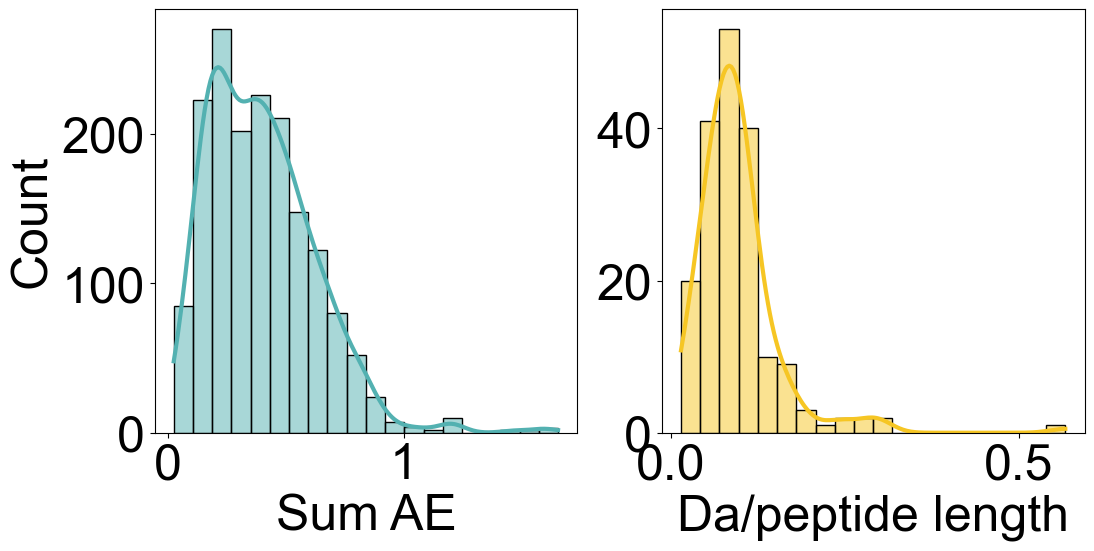

In [12]:
import seaborn as sns


fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))

# # Plotting with complementary colors
# sns.histplot([x[0] for x in envelope_errors], bins=20, kde=True, ax=axes[0], color="#FF6347")
# sns.histplot(uptake_errors_array, bins=20, kde=True, ax=axes[1], color="#4682B4")


color_1 = "#53b1b1"  # A standard blue color
color_2 = "#f6c624"  # A teal color

# Plotting with chosen colors
sns.histplot([x[0] for x in envelope_errors], bins=20, kde=True, ax=axes[0], color=color_1)
sns.histplot(uptake_errors_array, bins=20, kde=True, ax=axes[1], color=color_2)

axes[1].set_ylabel("")
axes[0].set_xlabel("Sum AE")
axes[1].set_xlabel("Da/peptide length")
fig.subplots_adjust(wspace=0.2)


In [13]:
from pigeon_feather.analysis import get_index_offset
from matplotlib.ticker import LogLocator


check_ana_obj = ana_apo_1
index_offset = get_index_offset(check_ana_obj, './data/6XG5_TRI.pdb')

uptake_errors = sorted(uptake_errors, key=lambda x: x[1].start, reverse=False)

num_subplots_per_figure = math.ceil(len(uptake_errors) / 2)
# num_subplots_per_figure = 250
num_figures = math.ceil(len(all_idfs) / num_subplots_per_figure)


for fig_index in range(num_figures):
    # Select the subset of errors for the current figure
    selected_uptake_errors = uptake_errors[fig_index * num_subplots_per_figure:(fig_index + 1) * num_subplots_per_figure]
    num_col = math.ceil(len(selected_uptake_errors) / 5)

    fig, axs = plt.subplots(num_col, 5, figsize=(9 * 5, 8 * num_col))  # Adjust subplot size as needed

    for i, error_tuple in enumerate(selected_uptake_errors):


        ax = axs[i // 5, i % 5]


        # Unpack error information
        peptide_data = error_tuple[1]


        ax.axhline(y=peptide_data.max_d, color='lightgray', linestyle='--', linewidth=5)

        check_fitted_peptide_uptake(
            check_ana_obj,
            hdxms_data_list,
            peptide_data,
            if_plot=True,
            state_name=check_state_name,
            figure=fig,
            ax=ax
        )

        #Retrieve and format the peptide identifier
        idf = peptide_data.identifier
        idf_start, idf_end = map(int, re.match(r"(-?\d+)-(-?\d+)", idf).groups())
        idf_seq = idf.split(" ")[1]
        ax.set_title(f"{idf_start - index_offset}-{idf_end - index_offset} {idf_seq}")

        ax.set_xlim(1e1, 1e5)
        ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=5))

        # y_max = ax.get_ylim()[1]
        # ax.set_ylim(-0.5, y_max + 1)
        pep = error_tuple[1]
        y_max = pep.theo_max_d/check_ana_obj.saturation
        ax.set_ylim(-0.5, y_max + 0.5)

        # light gray dotted line at max deuteration


        handles, labels = ax.get_legend_handles_labels()
        new_labels = [label for label in labels if label.isdigit()]
        new_handles = [handle for handle, label in zip(handles, labels) if label.isdigit()]
        ax.legend(new_handles, new_labels, title='replicate', title_fontsize='small')

    # Layout adjustment and save
    fig.tight_layout()
    fig.savefig(f"{results_path}/ecDHFR_uptake_errors_{check_state_name}_{fig_index}.pdf")


If the fitting is poor, do not proceed. Check the parameters in the sampling to ensure they agree with the experimental conditions. You may also need to remove outlier peptides and rerun the sampling. An outlier might be a peptide that exchanges a lot while its neighbors barely exchange (examples in the tutorial dataset: 78-92 VDEAIAACGDVPEIM, 75-78 VKSV).
